In [1]:
import os
import glob
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.layers import TimeDistributed 
import tkinter as tk
from tkinter import filedialog
from pydub import AudioSegment
import sounddevice as sd
from PIL import Image, ImageTk 

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
def extract_features(file_path):
    audio, sr = librosa.load(file_path, res_type='kaiser_fast')
    features = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13).T, axis=0)
    return features


In [3]:
data = []
labels = []
for folder_name in os.listdir('archive\TESS Toronto emotional speech set data\datasets'):
    folder_path = os.path.join('archive\TESS Toronto emotional speech set data\datasets', folder_name)
    for file_path in glob.glob(os.path.join(folder_path, '*.wav')):
        print(file_path)
        features = extract_features(file_path)
        data.append(features)
        labels.append(folder_name)

archive\TESS Toronto emotional speech set data\datasets\angry\OAF_back_angry.wav
archive\TESS Toronto emotional speech set data\datasets\angry\OAF_bar_angry.wav
archive\TESS Toronto emotional speech set data\datasets\angry\OAF_base_angry.wav
archive\TESS Toronto emotional speech set data\datasets\angry\OAF_bath_angry.wav
archive\TESS Toronto emotional speech set data\datasets\angry\OAF_bean_angry.wav
archive\TESS Toronto emotional speech set data\datasets\angry\OAF_beg_angry.wav
archive\TESS Toronto emotional speech set data\datasets\angry\OAF_bite_angry.wav
archive\TESS Toronto emotional speech set data\datasets\angry\OAF_boat_angry.wav
archive\TESS Toronto emotional speech set data\datasets\angry\OAF_bone_angry.wav
archive\TESS Toronto emotional speech set data\datasets\angry\OAF_book_angry.wav
archive\TESS Toronto emotional speech set data\datasets\angry\OAF_bought_angry.wav
archive\TESS Toronto emotional speech set data\datasets\angry\OAF_burn_angry.wav
archive\TESS Toronto emotion

In [4]:
import pandas as pd

df = pd.DataFrame(data)
df['label'] = labels

df.to_csv('extracted_features_testDatasets.csv', index=False)

Epoch 1/75
60/60 [==============================] - 11s 45ms/step - loss: 1.9154 - accuracy: 0.1703 - val_loss: 1.7689 - val_accuracy: 0.2062
Epoch 2/75
60/60 [==============================] - 1s 19ms/step - loss: 1.8542 - accuracy: 0.1719 - val_loss: 1.7597 - val_accuracy: 0.2604
Epoch 3/75
60/60 [==============================] - 1s 16ms/step - loss: 1.8326 - accuracy: 0.1724 - val_loss: 1.7805 - val_accuracy: 0.2375
Epoch 4/75
60/60 [==============================] - 1s 20ms/step - loss: 1.8029 - accuracy: 0.1911 - val_loss: 1.7748 - val_accuracy: 0.2188
Epoch 5/75
60/60 [==============================] - 1s 19ms/step - loss: 1.7974 - accuracy: 0.2042 - val_loss: 1.7468 - val_accuracy: 0.2188
Epoch 6/75
60/60 [==============================] - 1s 16ms/step - loss: 1.7748 - accuracy: 0.2073 - val_loss: 1.7211 - val_accuracy: 0.2292
Epoch 7/75
60/60 [==============================] - 1s 19ms/step - loss: 1.7519 - accuracy: 0.2151 - val_loss: 1.7051 - val_accuracy: 0.2188
Epoch 8/75
6

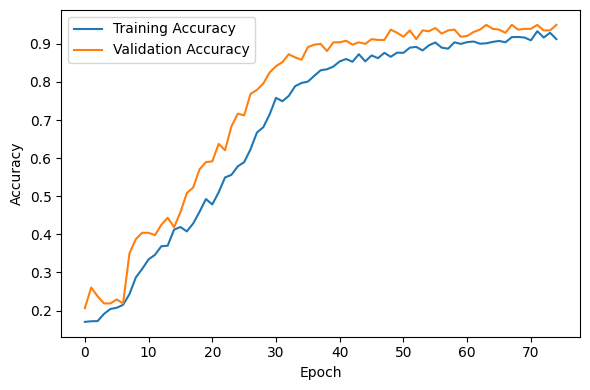

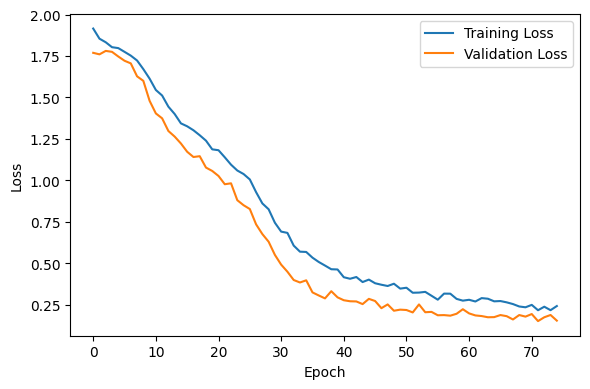

15/15 [==============================] - 0s 6ms/step - loss: 0.1530 - accuracy: 0.9500
Test loss: 0.15299370884895325
Test accuracy: 0.949999988079071


In [5]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

X_train = np.array(X_train)[:, np.newaxis, :]
X_test = np.array(X_test)[:, np.newaxis, :]

model = Sequential()
model.add(TimeDistributed(Dense(256, activation='relu'), input_shape=(1, X_train.shape[2])))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=75, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Extract training and validation accuracy and loss from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.figure(figsize=(6, 4))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('accuracy_plot.png')  # Simpan gambar akurasi

# Plot and save loss
plt.figure(figsize=(6, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('loss_plot.png') 
plt.show()

loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

In [6]:
model.save("model_terbaik.h5");

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:

def predict_emotion(audio_file):
    best_model = tf.keras.models.load_model('model_terbaik.h5')
    features = extract_features(audio_file)
    features = features[np.newaxis, np.newaxis, :]  
    print("Features shape:", features.shape)
    print("Features:", features)

    predicted_probabilities = best_model.predict(features)
    print("Predicted probabilities shape:", predicted_probabilities.shape)
    print("Predicted probabilities:", predicted_probabilities)

    predicted_label_index = np.argmax(predicted_probabilities)
    print("Predicted label index:", predicted_label_index)

    predicted_emotion = label_encoder.classes_[predicted_label_index]
    print("Predicted emotion:", predicted_emotion)


    # Emotion mapping for TESS dataset
    emotion_mapping = {
        'angry': 'ANGRY',
        'disgust': 'DISGUST',
        'fear': 'FEAR',
        'happy': 'HAPPY',
        'neutral': 'NEUTRAL',
        'sad': 'SAD',
    }

    
    recognizable_emotion = emotion_mapping.get(predicted_emotion)
    return recognizable_emotion


In [8]:
# import tensorflow as tf
# import librosa
# import numpy as np

# # Fungsi untuk memuat model dari file .h5
# def load_model(model_path):
#     model = tf.keras.models.load_model(model_path)
#     return model

# # Fungsi untuk memproses data audio dan melakukan prediksi
# def predict_audio_class(model, audio_path):
#     # Muat audio menggunakan librosa
#     audio_data, _ = librosa.load(audio_path, sr=44100)

#     # Lakukan ekstraksi fitur audio (misalnya, MFCC)
#     mfccs = librosa.feature.mfcc(y=audio_data, sr=44100, n_mfcc=13)

#     # Normalisasi data
#     mfccs = (mfccs - np.mean(mfccs)) / np.std(mfccs)

#     # Reshape data agar sesuai dengan input model
#     mfccs = mfccs.reshape(1, mfccs.shape[0], mfccs.shape[1])

#     # Lakukan prediksi
#     predictions = model.predict(mfccs)

#     # Interpretasikan hasil prediksi (misalnya, ambil kelas dengan nilai tertinggi)
#     predicted_class = np.argmax(predictions)

#     return predicted_class

# # Path ke model .h5
# model_path = 'model_terbaik.h5'

# # Path ke file audio yang akan diprediksi
# audio_path = 'samples/sample 1.wav'

# # Memuat model
# model = load_model(model_path)

# # Melakukan prediksi
# predicted_class = predict_audio_class(model, audio_path)

# # Output hasil prediksi
# print(f'Hasil prediksi kelas audio: {predicted_class}')


In [34]:
import sounddevice as sd
from scipy.io import wavfile

class EmotionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Emotion Prediction")
        self.root.configure(bg='#2C3333')

        self.emotion_to_emoji = {
            "HAPPY": "emoji/Happy.jpg",
            "SAD": "emoji/Sad.jpg",
            "ANGRY": "emoji/Angry.jpg",
            "NEUTRAL": "emoji/Neutral.jpg",
            "FEAR": "emoji/Fear.jpg",
            "DISGUST": "emoji/Disgust.jpg"
        }

        self.emoji_image = None
        self.prediction_history = []

        self.show_home_page()

    def show_home_page(self):
        self.clear_window()

        label = tk.Label(self.root, text="Emotion Recognition",
                         font=('Poppins bold', 16))
        label.pack(pady=18)

        audio_button = tk.Button(self.root, text="Prediksi suara", font=(
            'Poppins', 8), command=self.show_audio_page,
            bg='#33691e', fg="#FBFBFB", width=14, height=1, pady=2)
        audio_button.pack(pady=0)

        history_button = tk.Button(self.root, text="Riwayat", font=(
            'Poppins', 8), command=self.show_history_page, bg='#283593', fg="#FBFBFB", width=14, height=1, pady=2)
        history_button.pack(pady=12)

        record_audio_button = tk.Button(self.root, text="Record Audio", font=('Poppins', 8), command=self.show_record_audio_page, bg='#FFA000', fg="#FBFBFB", width=14, height=1, pady=2)
        record_audio_button.pack(pady=12)

    def show_record_audio_page(self):
        self.clear_window()

        canvas = tk.Canvas(self.root, width=500, height=500, bg='#FFFFFF')
        canvas.pack()

        title_label = tk.Label(self.root, text='Audio Recording', font=('Poppins bold', 26), bg="#FFFFFF", fg="#395B64")
        canvas.create_window(250, 50, window=title_label)

        file_name_label = tk.Label(self.root, text="File Name (.wav):", font=('Poppins', 10))
        canvas.create_window(250, 120, window=file_name_label)

        self.file_name_entry = tk.Entry(self.root, font=('Poppins', 10))
        canvas.create_window(250, 150, window=self.file_name_entry)

        record_button = tk.Button(self.root, text="Record", font=('Poppins', 9), command=self.start_recording, bg='#E7F6F2', fg="#395B64", width=14, height=1, pady=2)
        canvas.create_window(250, 200, window=record_button)

        back_button = tk.Button(self.root, text="Back to home", font=('Poppins', 9), command=self.show_home_page, bg='#E7F6F2', fg="#395B64", width=14, height=1, pady=2)
        canvas.create_window(250, 400, window=back_button)

    def start_recording(self):
        self.audio_buffer = []  # To store the audio data

        # Configure the audio recording parameters (adjust as needed)
        sample_rate = 44100  # Samples per second
        duration = 5  # Recording duration in seconds

        def audio_callback(indata, frames, time, status):
            if status:
                print(status, file=sys.stderr)
            if any(indata):
                self.audio_buffer.append(indata.copy())

        try:
            with sd.InputStream(callback=audio_callback, channels=1, samplerate=sample_rate):
                sd.sleep(int(duration * 1000))
        except Exception as e:
            print("Error during audio recording:", str(e))

        if hasattr(self, 'audio_buffer') and len(self.audio_buffer) > 0:
            file_name = self.file_name_entry.get()
            if not file_name:
                file_name = "recorded_audio.wav"

            # Save the audio data as a .wav file
            audio_data = np.concatenate(self.audio_buffer, axis=0)
            wavfile.write(file_name, sample_rate, audio_data)
            print("Audio recording saved as", file_name)


    def show_audio_page(self):
        self.clear_window()

        canvas = tk.Canvas(self.root, width=500, height=500, bg='#FFFFFF')
        canvas.pack()

        title_label = tk.Label(self.root, text='Speech Recognition', font=(
            'Poppins bold', 26), bg="#FFFFFF", fg="#395B64")
        canvas.create_window(250, 50, window=title_label)

        def upload_audio():
            file_path = filedialog.askopenfilename(
                filetypes=[("Audio Files", "*.wav")])
            if file_path:
                predicted_emotion = predict_emotion(file_path)
                emotion_label.config(text=predicted_emotion)

                self.prediction_history.append(
                    (os.path.basename(file_path), predicted_emotion))

                emoji_image_path = self.emotion_to_emoji.get(predicted_emotion)
                if emoji_image_path:
                    emoji_image = Image.open(emoji_image_path)
                    emoji_image = emoji_image.resize(
                        (100, 100), Image.ANTIALIAS)
                    self.emoji_image = ImageTk.PhotoImage(emoji_image)
                    emoji_label.config(image=self.emoji_image)

        upload_button = tk.Button(self.root, text='Upload Audio', font=(
            'Poppins', 9), command=upload_audio, bg='#E7F6F2', fg="#395B64", width=14, height=1, pady=2)
        canvas.create_window(250, 150, window=upload_button)

        emotion_label = tk.Label(
            self.root, text='PREDICTED EMOTION WILL BE DISPLAY HERE', bg="#FFFFFF", font=('Poppins', 11))
        canvas.create_window(250, 200, window=emotion_label)

        emoji_label = tk.Label(self.root, image=None, bg="#FFFFFF")
        canvas.create_window(250, 300, window=emoji_label)

        back_button = tk.Button(
            self.root, text="Back to home", font=('Poppins', 9), command=self.show_home_page, bg='#E7F6F2', fg="#395B64", width=14, height=1, pady=2)
        canvas.create_window(250, 400, window=back_button)

    def show_history_page(self):
        self.clear_window()

        canvas = tk.Canvas(self.root, width=500, height=500, bg='#FFFFFF')
        canvas.pack()

        label = tk.Label(self.root, text="Prediction History",
                         font=('Poppins bold', 16), bg="#FFFFFF", fg="#395B64")
        canvas.create_window(250, 50, window=label)

        if self.prediction_history:
            for index, (file_name, predicted_emotion) in enumerate(self.prediction_history, start=1):
                history_text = f"{index}. File: {file_name}, Emotion: {predicted_emotion}"
                history_label = tk.Label(self.root, text=history_text, font=('Poppins', 10),bg="#FFFFFF", fg="#395B64")
                canvas.create_window(250, 100 + index * 30,
                                     window=history_label)
        else:
            no_history_label = tk.Label(
                self.root, text="No prediction history available.", font=('Poppins', 10),bg="#FFFFFF", fg="#B2533E")
            canvas.create_window(250, 150, window=no_history_label)

        back_button = tk.Button(
            self.root, text="Back to home", font=('Poppins', 9), command=self.show_home_page, bg='#E7F6F2', fg="#395B64", width=14, height=1, pady=2)
        canvas.create_window(250, 400, window=back_button)

    def clear_window(self):
        for widget in self.root.winfo_children():
            widget.destroy()

if __name__ == "__main__":
    root = tk.Tk()
    app = EmotionApp(root)
    root.mainloop()

Audio recording saved as hantu.wav
Features shape: (1, 1, 13)
Features: [[[-652.0087      77.63106      2.9257648   14.969014   -13.272343
     -1.7194856  -10.42312     19.21064    -24.629923   -13.039763
     -2.7275152  -25.71615     -2.9025686]]]
1/1 [==============================] - 1s 1s/step
Predicted probabilities shape: (1, 6)
Predicted probabilities: [[6.7621949e-03 2.7750207e-03 1.5767336e-01 8.3271670e-01 6.3893982e-05
  8.8398037e-06]]
Predicted label index: 3
Predicted emotion: happy


C:\Users\User\AppData\Local\Temp\ipykernel_2492\1778492696.py:118: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  (100, 100), Image.ANTIALIAS)


Audio recording saved as blokkk.wav
Features shape: (1, 1, 13)
Features: [[[-552.5893      97.31465      5.01619     26.335323   -44.16275
    -15.916289    14.975269    10.7210245  -44.392822    -7.914518
    -12.313771   -18.944647     3.3065016]]]
1/1 [==============================] - 1s 964ms/step
Predicted probabilities shape: (1, 6)
Predicted probabilities: [[1.1153511e-01 2.5102920e-03 6.5459818e-01 2.3106550e-01 2.3893152e-04
  5.1992785e-05]]
Predicted label index: 2
Predicted emotion: fear
Audio recording saved as terntaty.wav
Features shape: (1, 1, 13)
Features: [[[-698.6968      75.51238    -13.292058     8.060292     3.5737185
     14.655088     7.33987     -1.8786771   -8.499421    -4.230317
     -5.235328   -10.60539     -6.2299914]]]
1/1 [==============================] - 1s 1s/step
Predicted probabilities shape: (1, 6)
Predicted probabilities: [[0.10206039 0.1264737  0.15640849 0.48570004 0.12870555 0.00065177]]
Predicted label index: 3
Predicted emotion: happy
Featur